In [140]:
%reset -f
# reset all stored variables

### Import necessary libraries

In [34]:
#numpy, pandas, matplotlib, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

#PyTorch and its sub modules
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch import nn


### Pre-process the data

In [35]:
os.getcwd() # get current directory

'/Users/yiboliang/math108c/-Math_108C-Final-Project'

In [36]:
Current_Directory=os.getcwd() 
Image_Directory=os.path.join(Current_Directory, "data/", "data") # get image directory
Image_Directory

'/Users/yiboliang/math108c/-Math_108C-Final-Project/data/data'

Let's first check out some of the images

the size of the image is (218, 178, 3)


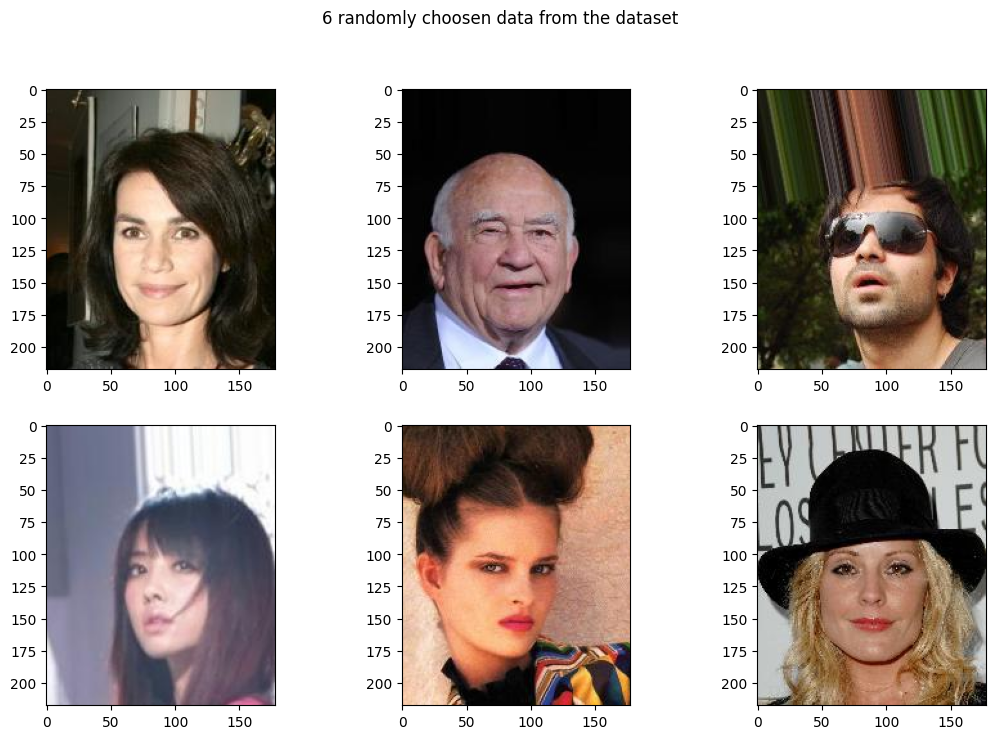

In [37]:
plt.figure(figsize=(13,8))
plt.suptitle("6 randomly choosen data from the dataset")
flag=0
for i in range(6):
        plt.subplot(2,3,i+1)
        choose_img_num=np.random.choice(os.listdir(Image_Directory)) # randomly pick a number 000001-005000
        image_path=os.path.join(Image_Directory, choose_img_num) # get the specific path of one image
        image=plt.imread(image_path)
        plt.imshow(image)
        
        if flag==0:
            print(f"the size of the image is {image.shape}")
            flag=1
plt.show()

In [38]:
We now transform the images into training data. We wrap it up as a **pytorch dataloader** in pytorch by a transform. I change the image into a square matrix and gray scale. The new individual figure has size $$R^{1 \times 224 \times 224}$$, where the number of channels become 1 due to gray-scale transform, and the new dimension number is chosen to be the cloest number that is bigger than 218 and is devisible by 32, so that we can experiment with multiple pooling layers later. The number of channels are moved to the front due to the setting of Pytorch. 

In [39]:
all_features=[]
flag=1
for train_features, _ in dataloader:
    all_features.append(train_features)
    
    if flag==1:
        print(f"Feature batch shape: {train_features.shape}") #used to check if the shape is correct
        flag=0

all_features=torch.cat(all_features, dim=0)
all_features.shape

Feature batch shape: torch.Size([64, 1, 224, 224])


torch.Size([5000, 1, 224, 224])

Below is a example of the data after transformation. As expected, it is in gray scale and it's a square image now. 

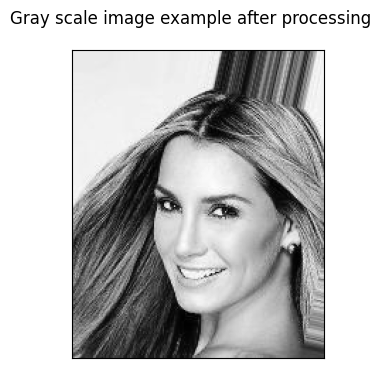

In [40]:
plt.figure(figsize=((6,4)))
plt.suptitle("Gray scale image example after processing")
plt.xticks(())
plt.yticks(())
plt.imshow(all_features[0].squeeze(), cmap="gray")

### Autoencoder model

Now we have all_features which contains the data we are going to use in training. It is in $$R^{5000 \times 1 \times 224 \times 224}$$
where the data contains 5000 images, and each image has the dimension layers $\times$ height $\times$ width. 

#### Encoder

Here I use a typical **convolution** approach, by multiple ""convolution-activation-pooling"" structure and fully connected layers at the end. 

In [41]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=10):
        
        super().__init__()
        
        self.conv1=nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=1)   #Output: 224x224x6
        self.relu1=nn.ReLU()
        self.pool1=nn.MaxPool2d(kernel_size=2, return_indices=True)      #Output: 112x112x6
    
        self.conv2=nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, stride=1, padding=1)  #Output: 112x112x12
        self.relu2=nn.ReLU()
        self.pool2=nn.MaxPool2d(kernel_size=2, return_indices=True)      #Output: 56x56x12
    
        self.conv3=nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1) #Output: 56x56x24
        self.relu3=nn.ReLU()
        self.pool3=nn.MaxPool2d(kernel_size=2, return_indices=True)      #Output: 28x28x24
        
        self.fc=nn.Sequential(
            nn.Flatten(),  #output: 18816
            nn.Linear(28*28*24, 28*28), #output: 784
            nn.ReLU(),
            nn.Linear(28*28, 10), #output: latent_dimension
        )

    def forward(self, x):
        #indices are returned for unpooling in decoder
        
        x = self.conv1(x)
        x = self.relu1(x)
        x, indice1 = self.pool1(x) 
        
        x = self.conv2(x)
        x = self.relu2(x)
        x, indice2 = self.pool2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x, indice3 = self.pool3(x)
        
        latent_representation =self.fc(x)
        
        indices=(indice1, indice2, indice3)
        return latent_representation, indices
        

#### Decoder

Here I use a typical **deconvolution** approach, by reversing the order of encoder, and more specifically fully connected layers at the begining and multiple ""unpooling-deconvolution-activation"" structure 

In [42]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=10):
        
        super().__init__()
        
        self.fc=nn.Sequential(
            nn.Linear(latent_dim, 28*28),
            nn.ReLU(),
            nn.Linear(28*28, 28*28*24),
        )
        
        self.unpool3 = nn.MaxUnpool2d(kernel_size=2)
        self.deconv3 = nn.ConvTranspose2d(in_channels=24, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU() 
        
        self.unpool2 = nn.MaxUnpool2d(kernel_size=2)
        self.deconv2 = nn.ConvTranspose2d(in_channels=12, out_channels=6, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
        self.unpool1 = nn.MaxUnpool2d(kernel_size=2)
        self.deconv1 = nn.ConvTranspose2d(in_channels=6, out_channels=1, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        

    def forward(self, x, indices):
        
        indice1, indice2, indice3=indices
        x=self.fc(x)
        x=x.view(-1, 24, 28, 28) #reshape into proper shape for unpooling and deconvolution, notice in this process the channels are moved in the front
        
        x=self.unpool3(x, indice3, output_size=torch.Size([x.size(0), 24, 56, 56]))
        x=self.deconv3(x)
        x=self.relu3(x)
        
        x=self.unpool2(x, indice2, output_size=torch.Size([x.size(0), 12, 112, 112]))
        x=self.deconv2(x)
        x=self.relu2(x)
        
        x=self.unpool1(x, indice1, output_size=torch.Size([x.size(0), 6, 224, 224]))
        x=self.deconv1(x)
        x=self.relu1(x)
        result=x.view(-1, 224, 224)
        return result
        

#### Final model: Combining Encoder and Decoder

In [43]:
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder=encoder
        self.decoder=decoder
    
    def forward(self, x):
        latent_representation, indices=self.encoder(x)
        result=self.decoder(latent_representation, indices)
    
        return result, latent_representation
    

In [44]:
model=Autoencoder(Encoder(), Decoder())
model

Autoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU()
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=18816, out_features=784, bias=True)
      (2): ReLU()
      (3): Linear(in_features=784, out_features=10, bias=True)
    )
  )
  (decoder): Decoder(
    (fc): Sequential(
      (0): Linear(in_features=10, out_features=784, bias=True)
      (1): ReLU()
      (2): Linear(in_features=784, out_features=18816, bias

### Training the model

We first define our loss function and optimization method. We use L2 norm and adam algorithm

In [45]:
loss_fn=nn.MSELoss() 
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)

In [46]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train() #traning mode
    
    total_loss=0
    
    for feature, _ in dataloader:
        result, latent_representation=model(feature) #the result
        loss=loss_fn(result, feature.reshape(-1,224,224)) #calculate loss
        total_loss+=loss.item() #take record of the tottal loss of each epoch
        
        #back-propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Loss on train data set this epoch {total_loss}")
    return total_loss
    

In [47]:
num_epoches=5
loss_record_train=[]

for epoch in range(num_epoches):
    print(f"epoch {epoch+1} ----------------------")
    total_loss_train=train_loop(dataloader, model, loss_fn, optimizer)
    loss_record_train.append(total_loss_train)

epoch 1 ----------------------
Loss on train data set this epoch 4.70783768966794
epoch 2 ----------------------
Loss on train data set this epoch 3.5696194022893906
epoch 3 ----------------------


### Plotting the training loss and Checking the decoded result

We first plot the training loss from loss function

In [ ]:
def plot_loss(loss_record_train):
    plt.figure(figsize=(5,5))
    plt.suptitle("Traning loss after each epoch")
    plt.plot(loss_record_train)
    
    plt.show()

The plot should be monotonically decreasing

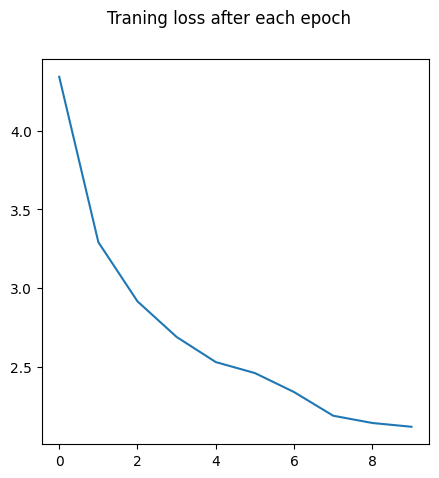

In [ ]:
plot_loss(loss_record_train)

We now check out decoded result. It should be vague but preserves the main features from original figure, since it is recovering info from the low latent dimension

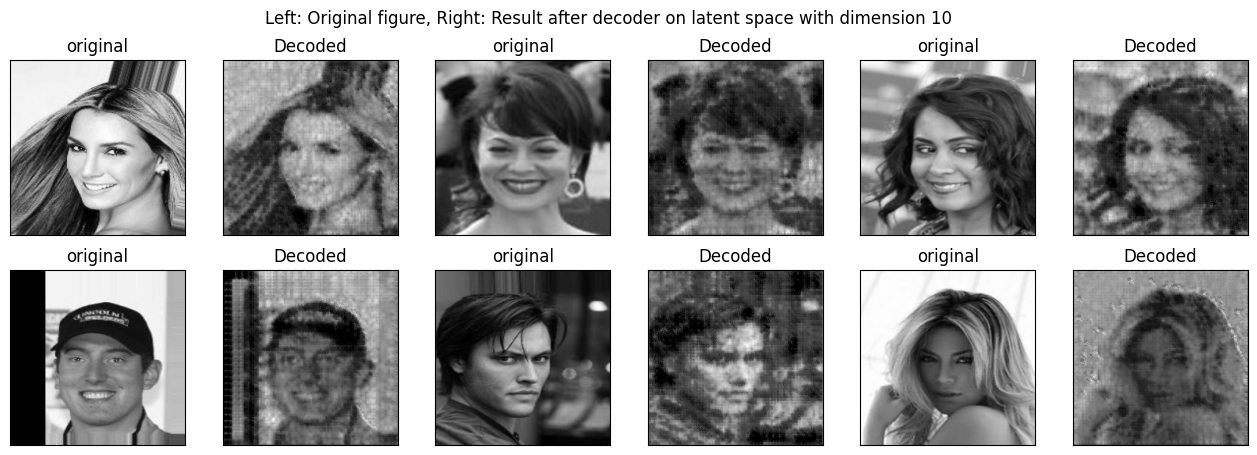

In [ ]:
plt.figure(figsize=(16,5))
plt.suptitle("Left: Original figure, Right: Result after decoder on latent space with dimension 10")
count=0
pos=0

for feature, label in dataloader:
     
    example=feature[count, :] #extract specific figure
    with torch.no_grad(): #Don't run back propagation!
        result, latent_representation=model(example.reshape(1,1,224,224))
    
    #plotting
    pos+=1
    ax1=plt.subplot(2,6,pos)
    ax1.set_title("original")
    plt.xticks(())
    plt.yticks(())
    plt.imshow(example.reshape(224,224,1), cmap="gray")
    
    pos+=1
    ax2=plt.subplot(2,6,pos)
    ax2.set_title("Decoded")
    plt.xticks(())
    plt.yticks(())
    plt.imshow(result.reshape(224,224,1), cmap="gray")
    
    #compare results of six images
    count+=1
    if count>=6:
        break


### Retrieving the Latent space

In [ ]:
for feature, label in dataloader:
    with torch.no_grad():
        result, latent_representation=model(feature)


In [ ]:
print(f"the shape of result is {result.shape}, the shape of latent space is {latent_representation.shape}")
torch.save(model.state_dict, 'Autoencoder.h5')

the shape of result is torch.Size([8, 38804]), the shape of latent space is torch.Size([8, 10])
